In [31]:
#importacion general de librerias y de visualizacion (matplotlib y seaborn)
%matplotlib notebook
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


#pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


In [32]:
df = pd.read_csv('train.csv', encoding='utf-8')
df['location'].fillna(value='sin location', inplace=True)
df['keyword'].fillna(value='sin keyword', inplace=True)

df['text'] = df.text.str.lower()
df['text'] = df.text.str.replace('%20', ' ')

df['keyword'] = df.keyword.str.lower()
df['keyword'] = df.keyword.str.replace('%20', ' ')

df['location'] = df.location.str.lower()
df['location'] = df.location.str.replace('%20', ' ')

# Funciones Generales

In [33]:

NOTICIEROS = ['cnn', 'bbc', 'reuters', 'blomberg', 'herald', 'today', 'herald', 'abc', 'fox', 'cbs', \
            'yorker', 'daily', 'financial', 'guardian', 'sun', 'observer', 'five', 'jazeera', 'news', 'live']
PAIS_DESASTRES = ['usa', 'united states', 'canada', 'japan', 'nigeria']
CIUDAD_DESASTRES = ['california', 'new york', 'nyc', 'hawaii']

TRAGEDIAS_CONOCIDAS = ['mh370', 'huracan', ]

CORTE_LENGHT_TEXT = 100

#Imprimir metricas de las predicciones
def print_metrics(y_test, y_pred):
    #auc = metrics.roc_auc_score(y_test, y_pred) #AUC
    precision = metrics.precision_score(y_test, y_pred) #Precisión
    accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy
    f1 = metrics.f1_score(y_test, y_pred) #F1 
    conf_matrix = metrics.confusion_matrix(y_test, y_pred) #Matriz de confusión
    #recall = metrics.recall_score(y_test, y_pred) #Recall 
    print('Accuracy:', accuracy, 'F1: ', f1,  'Precisión: ', precision)

# Referencia a un diario o noticiero
def news_ref(text):
    for word in text.split():
        if word in NOTICIEROS:
            return True
    return False

#Categoría ancho mensajes
def text_lenght_category(text):
    if len(text) > CORTE_LENGHT_TEXT:
        return True
    else:
        return False

#Pais de desastre
def es_pais_de_desastres(text):
    for word in text.split():
        if word in PAIS_DESASTRES:
            return True
    return False

#Ciudad de desastre
def es_ciudad_de_desastres(text):
    for word in text.split():
        if word in CIUDAD_DESASTRES:
            return True
    return False

In [34]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import re


stops = set(stopwords.words("english"))
def preparar_texto(text):
    lista = text.split()
    lista_sw = [limpiar_texto(word) for word in lista if not word in stops]
    return ( " ".join(lista_sw))

englishStemmer=SnowballStemmer("english")
def limpiar_texto(word):
    #word = englishStemmer.stem(word)
    word = word.replace('#', '')
    if word.startswith('http') | word.startswith('http'):
        word = ''
    word = re.sub('[^A-Za-z0-9]+', ' ', word)
    return word


In [35]:
df['text_sin_sw'] = df.text.apply(preparar_texto)

df['length'] = df.text_sin_sw.apply(len)


df['http'] = df.text.str.contains('http')
df['carita_alegre'] = df.text.str.contains(':\)')
df['carita_triste'] = df.text.str.contains(':\(')
#df['cant_stopwords'] = df.text.apply(lambda x: len(set(x.split()) & stops))


df['ref_noticias'] = df.text_sin_sw.apply(news_ref)

df['zona_desastres'] = df.text_sin_sw.apply(es_ciudad_de_desastres) |\
                        df.text_sin_sw.apply(es_pais_de_desastres)


'''
X = df[['location', 'text_sin_sw', 'target', 'http_hashtag', 'carita_alegre', 'carita_triste', 'length_verdadero', 'ref_noticias', 'zona_desastres']].join(encoded)
X[X.target == 1].sample(400).to_csv('data/tw_reales.csv')
X[X.target == 0].sample(400).to_csv('data/tw_falsos.csv')
df.sample(100)
'''

#serie = df[df.target == 0]['text_sin_sw'].str.split(expand=True).stack().value_counts()
#serie.to_csv('data/tw_top_words_0.csv')
#df[df.zona_desastres == 1].to_csv('data/sampple.csv')

df

,id,keyword,location,text,target,text_sin_sw,length,http,carita_alegre,carita_triste,ref_noticias,zona_desastres
0,1,sin keyword,sin location,our deeds are the reason of this #earthquake m...,1,deeds reason earthquake may allah forgive us,44,False,False,False,False,False
1,4,sin keyword,sin location,forest fire near la ronge sask. canada,1,forest fire near la ronge sask canada,38,False,False,False,False,True
2,5,sin keyword,sin location,all residents asked to 'shelter in place' are ...,1,residents asked shelter place notified offic...,91,False,False,False,False,False
3,6,sin keyword,sin location,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive wildfires evacuation ord...,60,False,False,False,False,True
4,7,sin keyword,sin location,just got sent this photo from ruby #alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,55,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,sin keyword,sin location,two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...,54,True,False,False,False,False
7609,10870,sin keyword,sin location,@aria_ahrary @thetawniest the out of control w...,1,aria ahrary thetawniest control wild fires c...,92,False,False,False,False,True
7610,10871,sin keyword,sin location,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,m1 94 01 04 utc 5km volcano hawaii,37,True,False,False,False,True
7611,10872,sin keyword,sin location,police investigating after an e-bike collided ...,1,police investigating e bike collided car littl...,118,False,False,False,False,False


# Pruebas

Accuracy: 0.7846638655462185 F1:  0.7132867132867133 Precisión:  0.8056872037914692


<IPython.core.display.Javascript object>


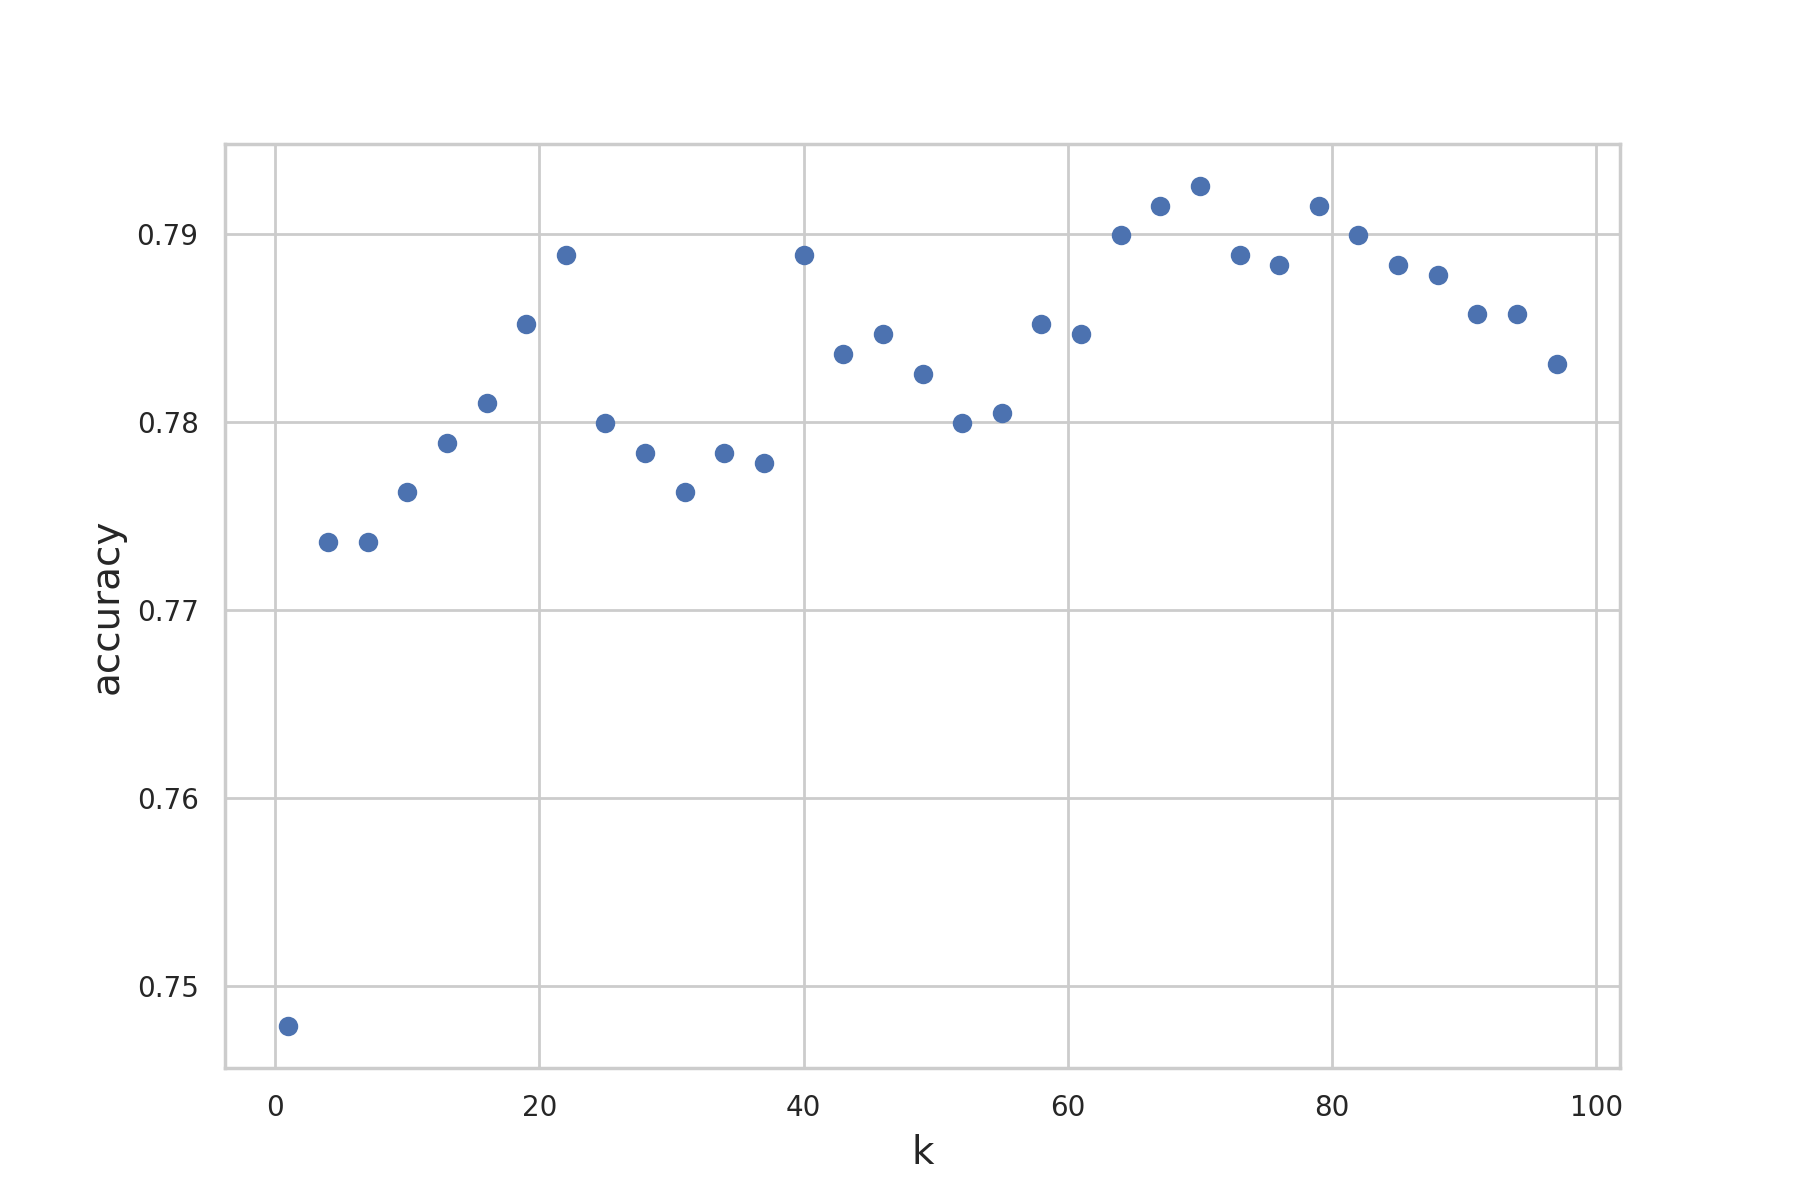

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

X = df['text'].values
y = df['target'].values

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 46)
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
print_metrics(y_test, y_pred)

k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()


# Datos de entrenamiento

In [37]:
from sklearn.preprocessing import LabelEncoder


#Codificando como categorias
#cat_features = ['ciudad_text', 'ciudad_location', 'pais_text', 'pais_location']
#encoder = LabelEncoder()

# Apliico a cada columna
#encoded = df[cat_features].apply(encoder.fit_transform)


#Datos de entrenameinto
#X = df[['http_hashtag', 'carita_alegre', 'carita_triste', 'length', 'ref_noticias', 'zona_desastres']].join(encoded)

y = df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
X = df.drop(columnas, axis=1)

X.head()


,length,http,carita_alegre,carita_triste,ref_noticias,zona_desastres
0,44,False,False,False,False,False
1,38,False,False,False,False,True
2,91,False,False,False,False,False
3,60,False,False,False,False,True
4,55,False,False,False,False,False


# 1. KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)


KNN = KNeighborsClassifier(n_neighbors = 20)
KNN.fit(X_train, y_train)

#Métricas
y_pred_knn = KNN.predict(X_test)
print_metrics(y_test, y_pred_knn)



Accuracy: 0.6349789915966386 F1:  0.5032165832737671 Precisión:  0.6006825938566553


# 2 . Regresión Logística

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

#Escalar valores atípicos
mix_max_scaler = MinMaxScaler() #StandardScaler()
X_train = mix_max_scaler.fit_transform(X_train)
X_test = mix_max_scaler.transform(X_test)

#Entrenamiento
LR = LogisticRegression(penalty='l2', max_iter=100, C=0.2, random_state = 1)
LR.fit(X_train, y_train)

#Métricas
y_pred_lr = LR.predict(X_test)
print_metrics(y_test, y_pred_lr)

Accuracy: 0.6433823529411765 F1:  0.5488372093023256 Precisión:  0.596820809248555


# 3. Gaussian NB

In [40]:
from sklearn.naive_bayes import GaussianNB

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# Train
GNB = GaussianNB()
GNB.fit(X_train, y_train)

#Predict
y_pred_gnb = GNB.predict(X_test)

#Metrics
print_metrics(y_test, y_pred_gnb)


Accuracy: 0.634453781512605 F1:  0.491970802919708 Precisión:  0.6050269299820467


# 4. Categorical NB

In [41]:
from sklearn.naive_bayes import CategoricalNB

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# Train
CNB = CategoricalNB()
CNB.fit(X_train, y_train)

#Predict
y_pred_cnb = CNB.predict(X_test)

#Metrics
print_metrics(y_test, y_pred_cnb)


Accuracy: 0.6370798319327731 F1:  0.566227244193346 Precisión:  0.5782051282051283


# 5. RFC

Accuracy: 0.6386554621848739 F1:  0.5382550335570468 Precisión:  0.5923190546528804


<IPython.core.display.Javascript object>


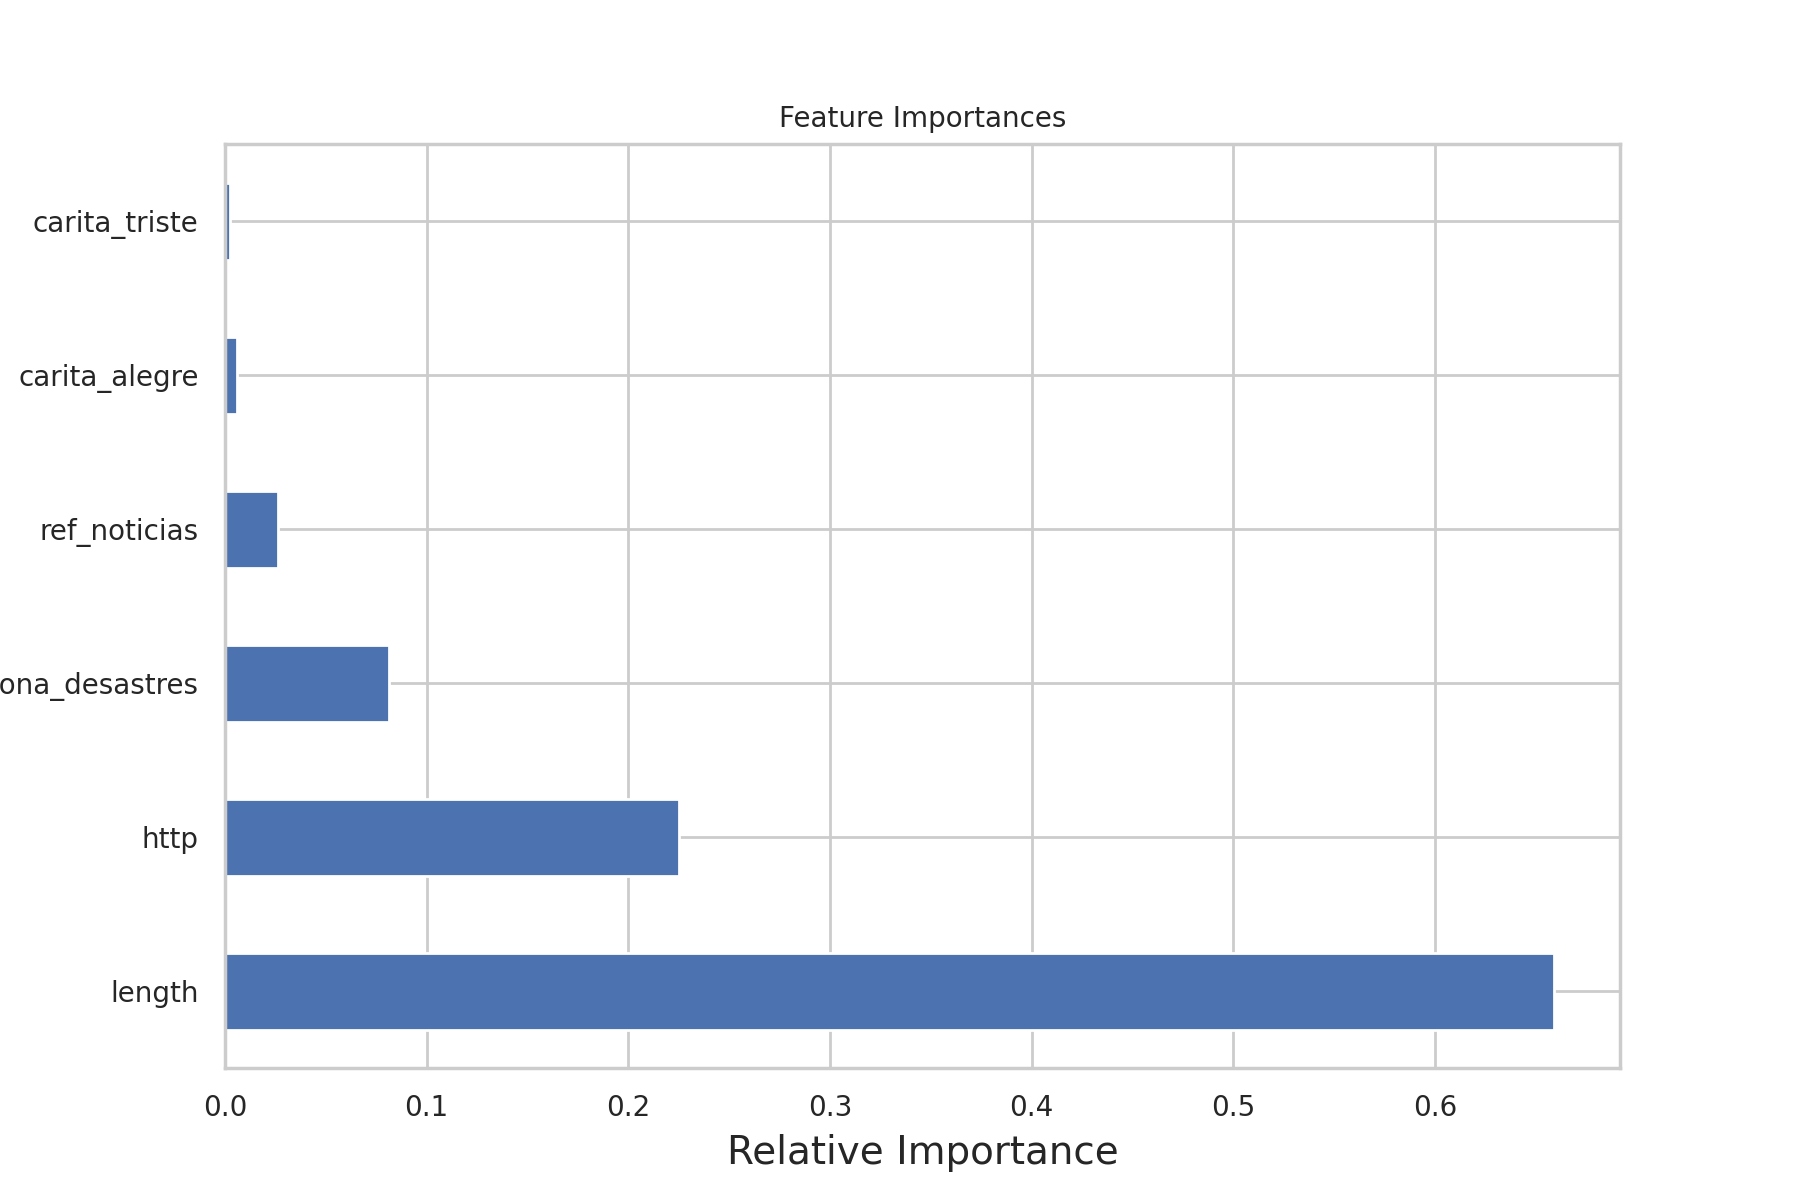

Feature ranking:
length                   0.6588049851
http                     0.2252567281
zona_desastres           0.0813383296
ref_noticias             0.0264328522
carita_alegre            0.0058909586
carita_triste            0.0022761464
dtype: float64


In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)


# Train
RFC = RandomForestClassifier(n_estimators = 20,  n_jobs=-1, random_state = 0)
RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#metrics
print_metrics(y_test, y_pred)

#Features
features = np.array(X_train.columns)
importances = RFC.feature_importances_
indices = np.argsort(importances)
    
serie = (pd.Series(RFC.feature_importances_, index=X_train.columns).nlargest(X_train.shape[1]))

plt.figure()
serie.plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

# Print the feature ranking
print("Feature ranking:")

print(serie)